In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import os
from tqdm import tqdm as tq
from torch.utils.data import WeightedRandomSampler
from sklearn.metrics import f1_score

# Parámetros
DATA_DIR = 'dataset-camera'
MODEL_PATH = 'camera_classifier.pth'
BATCH_SIZE = 64
NUM_EPOCHS = 10
LEARNING_RATE = 1e-4
VAL_SPLIT = 0.3
NUM_WORKERS = 8
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transformaciones
# Data augmentation para entrenamiento, solo transformaciones básicas para validación
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset con transformaciones distintas para train y val
dataset = datasets.ImageFolder(DATA_DIR, transform=None)
class_names = dataset.classes
print(f"Clases detectadas: {class_names}")

val_size = int(len(dataset) * VAL_SPLIT)
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Asignar transformaciones específicas
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

# Calcular pesos para el sampler según la frecuencia de clases
targets = [dataset.targets[i] for i in train_dataset.indices]
class_sample_count = torch.tensor([(torch.tensor(targets) == t).sum() for t in range(len(class_names))], dtype=torch.float)
weight = 1. / class_sample_count
samples_weight = torch.tensor([weight[t] for t in targets])

sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# Modelo preentrenado
model = models.resnet18(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model = model.to(DEVICE)

# Pérdida y optimizador (puedes usar class weights en CrossEntropyLoss si lo prefieres)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

best_val_loss = float('inf')
patience = 2
counter = 0
# Entrenamiento
for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    traim_bar = tq(train_loader, desc="Entrenando", unit="batch")

    for inputs, labels in traim_bar:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
        traim_bar.set_postfix(loss=running_loss / total, acc=correct / total)

    train_loss = running_loss / total
    train_acc = correct / total

    # Validación
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    val_bar = tq(val_loader, desc="Validando", unit="batch")
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_bar:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
            
            val_bar.set_postfix(loss=val_loss / val_total, acc=val_correct / val_total)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= val_total
    val_acc = val_correct / val_total
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - "
          f"Train loss: {train_loss:.4f}, acc: {train_acc:.4f} - "
          f"Val loss: {val_loss:.4f}, acc: {val_acc:.4f}, F1: {f1:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), MODEL_PATH)
        print(f"Mejor modelo guardado en {MODEL_PATH}")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping activado. No mejora en la validación.")
            break



Clases detectadas: ['close-up_behind_the_goal', 'close-up_corner', 'close-up_player_or_field_referee', 'close-up_side_staff', 'goal_line_technology_camera', 'inside_the_goal', 'main_behind_the_goal', 'main_camera_center', 'main_camera_left', 'main_camera_right', 'other', 'public', 'spider_camera']
Epoch 1/10


Validando: 100%|██████████| 394/394 [00:20<00:00, 19.68batch/s, acc=0.81, loss=0.61]  


Epoch 1/10 - Train loss: 0.4049, acc: 0.8813 - Val loss: 0.6099, acc: 0.8104, F1: 0.8293
Mejor modelo guardado en camera_classifier.pth
Epoch 2/10


Validando: 100%|██████████| 394/394 [00:20<00:00, 19.68batch/s, acc=0.838, loss=0.56] 


Epoch 2/10 - Train loss: 0.1324, acc: 0.9617 - Val loss: 0.5597, acc: 0.8384, F1: 0.8508
Mejor modelo guardado en camera_classifier.pth
Epoch 3/10


Validando: 100%|██████████| 394/394 [00:19<00:00, 19.71batch/s, acc=0.851, loss=0.577]


Epoch 3/10 - Train loss: 0.0792, acc: 0.9778 - Val loss: 0.5772, acc: 0.8507, F1: 0.8570
Epoch 4/10


Validando: 100%|██████████| 394/394 [00:20<00:00, 19.69batch/s, acc=0.837, loss=0.611]

Epoch 4/10 - Train loss: 0.0659, acc: 0.9810 - Val loss: 0.6108, acc: 0.8373, F1: 0.8491
Early stopping activado. No mejora en la validación.


In [2]:
from sklearn.metrics import confusion_matrix, accuracy_score
import torch

def calculate_confusion_matrix(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    acc = accuracy_score(all_labels, all_preds)
    return cm, acc

# Calcular la matriz de confusión
cm, acc = calculate_confusion_matrix(model, val_loader, DEVICE)
print("Accuracy en validación:", acc)

Accuracy en validación: 0.8373348148736061


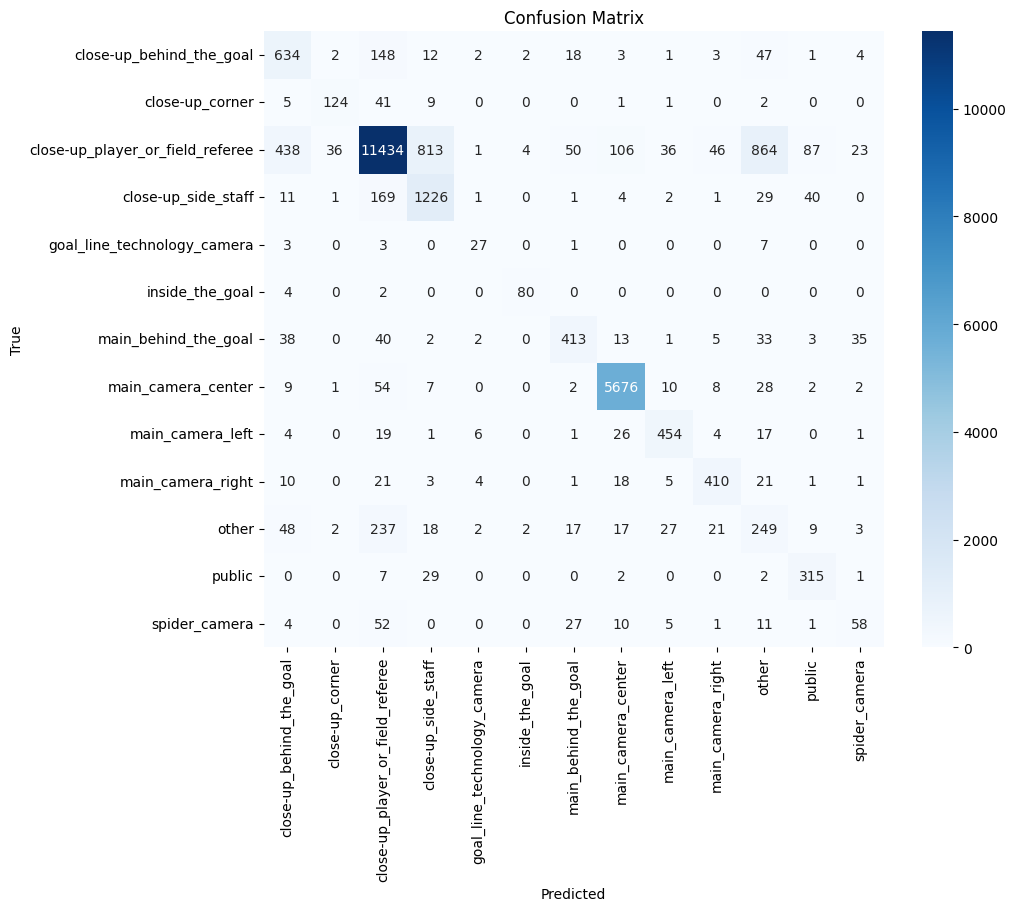

In [3]:
#visualizar la matriz de confusión
import matplotlib.pyplot as plt
import seaborn as sns
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                 xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
plot_confusion_matrix(cm, class_names)

In [4]:
""" import CameraClassifier as cc
MODEL_PATH = 'camera_classifierv2.pth'
camera_classifier = cc.CameraClassifier(MODEL_PATH)
image_path = './SoccerNet/calibration/challenge/00008.jpg'  

result = camera_classifier.predict(image_path)
probabilities = camera_classifier.predict_proba(image_path)
print(f"La imagen '{image_path}' ha sido clasificada como: {result}, con probabilidades:")
for class_name, prob in probabilities.items():
    print(f"{class_name}: {prob:.4f}") """

' import CameraClassifier as cc\nMODEL_PATH = \'camera_classifierv2.pth\'\ncamera_classifier = cc.CameraClassifier(MODEL_PATH)\nimage_path = \'./SoccerNet/calibration/challenge/00008.jpg\'  \n\nresult = camera_classifier.predict(image_path)\nprobabilities = camera_classifier.predict_proba(image_path)\nprint(f"La imagen \'{image_path}\' ha sido clasificada como: {result}, con probabilidades:")\nfor class_name, prob in probabilities.items():\n    print(f"{class_name}: {prob:.4f}") '

In [5]:
#quiero un listado de todo el dataset con el dataset para 
# cada imagen y su clase predicha
dataset = datasets.ImageFolder(DATA_DIR, transform=val_transform)
all_loader = DataLoader(dataset, batch_size=124, shuffle=False, num_workers=NUM_WORKERS)

In [6]:
model.eval()
incorrect_predictions = []

with torch.no_grad():
    for batch_idx, (inputs, labels) in enumerate(tq(all_loader, desc="Procesando imágenes", unit="batch")):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        for i in range(inputs.size(0)):
            img_path = dataset.imgs[batch_idx * BATCH_SIZE + i][0]
            if class_names[preds[i]] != class_names[labels[i]]:
                incorrect_predictions.append((img_path, class_names[labels[i]], class_names[preds[i]]))

Procesando imágenes: 100%|██████████| 678/678 [01:04<00:00, 10.44batch/s]


In [7]:
print(f"Total de imágenes incorrectamente clasificadas: {len(incorrect_predictions)}")
for img_path, true_class, pred_class in incorrect_predictions:
    if 'close-up_player_or_field_referee' in img_path:
        print(f"Imagen: {img_path}, Clase verdadera: {true_class}, Clase predicha: {pred_class}")

Total de imágenes incorrectamente clasificadas: 8737
Imagen: dataset-camera/close-up_player_or_field_referee/2014-11-04 - 22-45 Arsenal 3 - 3 Anderlecht_1_698.jpg, Clase verdadera: close-up_player_or_field_referee, Clase predicha: close-up_behind_the_goal
Imagen: dataset-camera/close-up_player_or_field_referee/2014-11-04 - 22-45 Arsenal 3 - 3 Anderlecht_2_1023.jpg, Clase verdadera: close-up_player_or_field_referee, Clase predicha: close-up_side_staff
Imagen: dataset-camera/close-up_player_or_field_referee/2014-11-04 - 22-45 Arsenal 3 - 3 Anderlecht_1_698.jpg, Clase verdadera: close-up_player_or_field_referee, Clase predicha: other
Imagen: dataset-camera/close-up_player_or_field_referee/2014-11-04 - 22-45 Arsenal 3 - 3 Anderlecht_2_1023.jpg, Clase verdadera: close-up_player_or_field_referee, Clase predicha: other
Imagen: dataset-camera/close-up_player_or_field_referee/2014-11-04 - 22-45 Arsenal 3 - 3 Anderlecht_2_1661.jpg, Clase verdadera: close-up_player_or_field_referee, Clase predich